In [ ]:
# Uncomment and run if installation does not exist in environment
#%pip install numpy
#%pip install pandas
#%pip install nibabel
#%pip install seaborn
#%pip install matplotlib
#%pip install nilearn
#%pip install pyrelimri

In [1]:
import sys
import os
import argparse
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import image, masking, plotting
from glob import glob
from pyrelimri import similarity
from itertools import product
from scipy.stats import norm
warnings.filterwarnings("ignore")

In [2]:
def nifti_cohensd_to_tstat(cohensd_img, n):
    """
    function converts NIfTI Cohen's image to t-statistic .

    :param tstat_img: NIfTI image containing Cohens, Nifti1Image.
    :param n: Sample size for calculating t-stat, Integer
    :return: NIfTI image containing t-stat.
    """
    # Get data array from the d stat image
    img = image.load_img(cohensd_img)
    d_data = img.get_fdata()
    # Calculate Cohen's d using the t_stat / sqrt(n) formula
    t_data = d_data * np.sqrt(n)
    # Create a NIfTI image containing Cohen's d, with the same properties as the input image
    tstat_img = image.new_img_like(img, t_data)

    return tstat_img
    
def extract_median(img_list, mask_img):
    data_list = []
    mask_name = os.path.basename(mask_img)
    mask = mask_name.split('.')[0]
    for img in img_list:
        base_name = os.path.basename(img)
        con, mni, motion, model, fwhm = base_name.split('_')[2:7]
    
        # get median value
        nifti_img = image.load_img(img)
        masked_data = masking.apply_mask(nifti_img, mask_img)
        median_est = np.round(np.median(masked_data), 3)
        
        data_list.append({
            'mask': mask,
            'con': con,
            'motion': motion,
            'model': model,
            'fwhm': fwhm,
            'median_est': median_est
        })
    return pd.DataFrame(data_list)

def calculate_average(img, mask):
    masked_data = masking.apply_mask(image.load_img(img), mask)
    return np.round(np.mean(masked_data), 3)
    
def roi_average(img_list, left_mask, right_mask):
    data_list = []
    for img in img_list:
        base_name = os.path.basename(img)
        con, mni, motion, model, fwhm = base_name.split('_')[2:7]
    
        # Calculate average values for left and right masks
        avg_left = calculate_average(img, left_mask)
        avg_right = calculate_average(img, right_mask)
        
        data_list.append({
            'con': con,
            'motion': motion,
            'model': model,
            'fwhm': fwhm,
            'avg_left': avg_left,
            'avg_right': avg_right
        })
    
    return pd.DataFrame(data_list)

def extract_median_rand(inp_dir,model_name, ses, task, subpra_mask, sub_mask, seed_list, n_range):
    data_list = []

    for seed_n in seed_list:
            for n in n_range:
                # set paths
                icc_path = f'{inp_dir}/seed-{seed_n}_subs-{n}_task-{task}_type-run_{model_name}_stat-est.nii.gz'
                msbtwn_path = f'{inp_dir}/seed-{seed_n}_subs-{n}_task-{task}_type-run_{model_name}_stat-btwnsub.nii.gz'
                mswthn_path = f'{inp_dir}/seed-{seed_n}_subs-{n}_task-{task}_type-run_{model_name}_stat-wthnsub.nii.gz'
                # load images
                icc_img = image.load_img(icc_path)
                msbtwn_img = image.load_img(msbtwn_path)
                mswthn_img = image.load_img(mswthn_path)
                #mask images
                icc_supra = masking.apply_mask(icc_img, subpra_mask)
                icc_sub = masking.apply_mask(icc_img, sub_mask)
                msbtwn_supra = masking.apply_mask(msbtwn_img, subpra_mask)
                msbtwn_sub = masking.apply_mask(msbtwn_img, sub_mask)
                mswthn_supra = masking.apply_mask(mswthn_img, subpra_mask)
                mswthn_sub = masking.apply_mask(mswthn_img, sub_mask)
                # extract median
                icc_supra_med = np.round(np.median(icc_supra), 3)
                icc_sub_med = np.round(np.median(icc_sub), 3)
                msbtwn_supra_med = np.round(np.median(msbtwn_supra), 3)
                msbtwn_sub_med = np.round(np.median(msbtwn_sub), 3) 
                mswthn_supra_med = np.round(np.median(mswthn_supra), 3)
                mswthn_sub_med = np.round(np.median(mswthn_sub), 3) 
                
                data_list.append({
                    'seed': seed_n,
                    'subsample_n': n,
                    'icc_supra': icc_supra_med,
                    'icc_sub': icc_sub_med,
                    'msbtwn_supra': msbtwn_supra_med,
                    'msbtwn_sub': msbtwn_sub_med,
                    'mswthn_supra': mswthn_supra_med,
                    'mswthn_sub': mswthn_sub_med
                })
    return pd.DataFrame(data_list)

def file_exists(file_path):
    return os.path.exists(file_path)

# if file doesnt exist, extract media and create file, otherwise load file 
def process_dataset(imgs, mask, out_file):
    if not file_exists(out_file):
        print(f'file {out_file} doesnt exist, creating')
        df = extract_median(imgs, mask)
        df.to_csv(out_file, sep='\t', index=False)
    else:
        print(f'Loading existing {out_file}')
        df = pd.read_csv(out_file, sep='\t')
    return df

def process_dataset_roi(imgs, left_mask, right_mask, out_file):
    if not file_exists(out_file):
        print(f'file {out_file} doesnt exist, creating')
        df = roi_average(imgs, left_mask=left_mask, right_mask=right_mask)
        df.to_csv(out_file, sep='\t', index=False)
    else:
        print(f'Loading existing {out_file}')
        df = pd.read_csv(out_file, sep='\t')
    return df

def mean_sd_img(list_imgs):
    # get data and stack it
    img_list = [image.load_img(img_path) for img_path in list_imgs]
    img_data = np.stack([img.get_fdata() for img in img_list], axis=-1)
    # calculate the mean + sd image
    mean_img_data = np.mean(img_data, axis=-1)
    sd_img_data = np.std(img_data, axis=-1)
    # convert back into space of icc imgs
    icc_mean_img = image.new_img_like(img_list[0], mean_img_data)
    icc_sd_img = image.new_img_like(img_list[0], sd_img_data)
    # return mean + sd img
    return icc_mean_img,icc_sd_img

def plot_icc_maps(maps, names, coordinates, vmax):
    num_maps = len(maps)
    num_rows = num_maps // 2 + num_maps % 2  # Calculate the number of rows based on the number of maps
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 12))

    for i, map_type in enumerate(maps):
        labels = names[i].split('_')
        est_lab = labels[1]
        #thresh_lab = labels[2]

        row = i // 2
        col = i % 2
        
        if num_rows == 1:  # If only one row, axes is not 2D
            plotting.plot_stat_map(map_type, display_mode='tiled', title=f'{est_lab}',
                                   cut_coords=coordinates, vmax=vmax, axes=axes[col])
        else:
            plotting.plot_stat_map(map_type, display_mode='tiled', title=f'{est_lab}',
                                   cut_coords=coordinates, vmax=vmax, axes=axes[row, col])


    plt.tight_layout()
    plt.show()


def plot_top_map(img, img_index, coordinates, vmax):
    plotting.plot_stat_map(img[img_index], display_mode='tiled',
                           cut_coords=coordinates, vmax=vmax)
    
    plt.tight_layout()
    plt.show()
    
def plot_dist_imgs(imgs, img_index, mask_supra, mask_sub, 
                   bins=500, ylim=(0, 1), xlim=(-5, 50), dec_round=1, xlab=''):
    masked_supra_data = masking.apply_mask(imgs[img_index], mask_supra)
    masked_sub_data = masking.apply_mask(imgs[img_index], mask_sub)

    # median for plots
    med_supra = np.median(masked_supra_data)
    med_sub = np.median(masked_sub_data)

    # Plot the distribution
    plt.hist(np.round(masked_supra_data, decimals=dec_round), bins=bins, edgecolor='black', color='black',
             alpha=1, label='supra-thresh', density=True)  # supra-threshold mask
    plt.hist(np.round(masked_sub_data, decimals=dec_round), bins=bins, edgecolor='black', color='yellow',
             alpha=0.6, label='sub-thresh', density=True)  # sub-threshold mask

    plt.axvline(med_supra, color='red', linestyle='dashed', linewidth=1, label='Median supra-thresh')
    plt.axvline(med_sub, color='blue', linestyle='dashed', linewidth=1, label='Median sub-thresh')
    plt.ylim(ylim[0], ylim[1])
    plt.xlim(xlim[0], xlim[1])

    plt.xlabel(f'{xlab}')
    plt.ylabel('Density')

    plt.legend()
    plt.show()

def dist_cohensd(min_img, max_img, mask,  bins=500, ylim=(0, 1), xlim=(-1, 1), dec_round=1, xlab=''):
    min_data = masking.apply_mask(min_img, mask)
    max_data = masking.apply_mask(max_img, mask)

    # mean + sd for cohens d est
    mean_min = np.mean(min_data)
    mean_max = np.mean(max_data)
    sd_min = np.std(min_data, ddof=1)
    sd_max = np.std(max_data, ddof=1)

    cohensd = (mean_max - mean_min) / np.sqrt((sd_min**2+sd_max**2)/2)
    
    # Plot the distribution
    plt.hist(np.round(min_data, decimals=dec_round), bins=bins,
             alpha=.5, label='Min. Image', density=True) 
    plt.hist(np.round(max_data, decimals=dec_round), bins=bins,
             alpha=.5, label='Max. Image', density=True)  
    plt.ylim(ylim[0], ylim[1])
    plt.xlim(xlim[0], xlim[1])

    plt.xlabel(f'{xlab}')
    plt.ylabel('Density')
    plt.title(f"Cohen's D Between Img1 and Img2: {round(cohensd,2)}")

    plt.legend()
    plt.show()

# Set Study/File info

In this section, setting relevant path variables for ABCD, AHRB or MLS samples. Then, loading the 240 images and creating output file names for the different model results.

In [3]:
sample='abcd' # sample, AHRB, MLS or abcd
calc_type='run' # session or run 
ses='baselineYear1Arm1' # abcd opt: baselineYear1Arm1/2YearFollowUpYArm1, MLS/AHRB opts: 1/2

In [4]:
# Set paths
if sample == 'abcd':
    task='MID'
    data_path=f'/scratch.global/mdemiden/analyses_reliability'
    out_dir= data_path
    icc_est=os.path.join(out_dir, "icc_mods", calc_type)
    group_out=os.path.join(out_dir, "group_lowmotion")
    file_out=os.path.join(out_dir,"file_output")
    analysis_path='/home/feczk001/mdemiden/analyses/Multiverse_Reliability/Stage2_Code/cluster_jobs'
    subj_list=os.path.join(analysis_path, "subj_ids", "lowmot_session-site13.tsv")
    seed_list=os.path.join(analysis_path, "subj_ids", "rand_seeds.tsv")
    icc_resamp=os.path.join(out_dir, "subsample", "icc_subsample",f'ses-{ses}')
    icc_resample_file=os.path.join(file_out,f'sample-{sample}_ses-baselineYear1Arm1_type-bootsrap_stats-icc.tsv')
    # load sub and supra masks
    mask_supra = os.path.join(analysis_path, "..", "brain_mask", "MNI152_wilson-supra.nii.gz")
    mask_sub = os.path.join(analysis_path, "..", "brain_mask", "MNI152_wilson-sub.nii.gz")
    left_nacc = os.path.join(analysis_path, "..", "brain_mask", "Left_NAcc.nii.gz")
    right_nacc = os.path.join(analysis_path, "..", "brain_mask", "Right_NAcc.nii.gz")
elif sample in ['AHRB','MLS']:
    data_path=os.path.join('/oak/stanford/groups/russpold/data',sample)
    out_dir=os.path.join(data_path,"derivatives","analyses","proj_reliability")
    icc_est=os.path.join(out_dir,"icc_mods",calc_type)
    group_out=os.path.join(out_dir,"group")
    analysis_path=os.path.join(data_path,"code","proj_reliability","Multiverse_Reliability","Stage2_Code","cluster_jobs")
    file_out=os.path.join(out_dir,"file_output")
    # load sub and supra masks
    mask_supra = os.path.join(analysis_path, "..", "brain_mask", "MNI152_wilson-supra.nii.gz")
    mask_sub = os.path.join(analysis_path, "..", "brain_mask", "MNI152_wilson-sub.nii.gz")
    left_nacc = os.path.join(analysis_path, "..", "brain_mask", "Left_NAcc.nii.gz")
    right_nacc = os.path.join(analysis_path, "..", "brain_mask", "Right_NAcc.nii.gz")
    if sample == 'MLS':
        task='reward'
    else:
        task='mid'
else:
    print('Incorrect sample provided. Options: abcd, AHRB, MLS')
    

In [5]:
# load ICC images
# icc 
icc_imgs = sorted(glob(os.path.join(icc_est,"*stat-est.nii.gz")))
# msbs 
bs_imgs = sorted(glob(os.path.join(icc_est,"*stat-btwnsub.nii.gz")))
# msws
ws_imgs = sorted(glob(os.path.join(icc_est,"*stat-wthnsub.nii.gz")))

print("Acquired lists:",
      len(icc_imgs),len(bs_imgs),len(ws_imgs))

Acquired lists: 240 240 240


In [6]:
# icc
out_icc_supra = os.path.join(file_out,f'sample-{sample}_type-{calc_type}_stats-est_mask-wilson-supra.tsv')
out_icc_sub = os.path.join(file_out,f'sample-{sample}_type-{calc_type}_stats-est_mask-wilson-sub.tsv')
out_icc_nacc = os.path.join(file_out,f'sample-{sample}_type-{calc_type}_stats-est_mask-nacc.tsv')
# msbs
out_bs_supra = os.path.join(file_out,f'sample-{sample}_type-{calc_type}_stats-bs_mask-wilson-supra.tsv')
out_bs_sub = os.path.join(file_out,f'sample-{sample}_type-{calc_type}_stats-bs_mask-wilson-sub.tsv')
out_bs_nacc = os.path.join(file_out,f'sample-{sample}_type-{calc_type}_stats-bs_mask-nacc.tsv')

# msw
out_ws_supra = os.path.join(file_out,f'sample-{sample}_type-{calc_type}_stats-ws_mask-wilson-supra.tsv')
out_ws_sub = os.path.join(file_out,f'sample-{sample}_type-{calc_type}_stats-ws_mask-wilson-sub.tsv')
out_ws_nacc = os.path.join(file_out,f'sample-{sample}_type-{calc_type}_stats-ws_mask-nacc.tsv')

# similarity
out_similarity= os.path.join(file_out,f'sample-{sample}_type-{calc_type}_stats-similarity.tsv')

## Calc concatenated df for model efficiences (motion, parameteization)

Setting study variables to calculate the model efficiencies. In this case, using the list of subjects and getting the directory path names. Taking the average across the FWHM and Runs, as models not impacts by FWHM but only the grouping variables: Model, Motion and Contrast types. 

In [7]:
# Model permutations
if sample in ['abcd', 'AHRB']:
    voxel = 2.4
    opts = np.array([1.5,  2, 2.5, 3, 3.5])
    fwhm_opt = list(np.round(voxel * opts, 1))
elif sample in 'MLS':
    voxel = 4
    inh_smooth_weight = .50
    opts = np.array([1.5, 2, 2.5, 3, 3.5])*inh_smooth_weight
    fwhm_opt = list(np.round(voxel * opts, 1))

# only including 4; opt 5 is opt3 + subj mFD < .9 & opt6 is opt4 + subj mFD < .9. 
motion_opt = ["opt1", "opt2", "opt3", "opt4"]
modtype_opt = ["CueMod", "AntMod", "FixMod"]

permutation_list = list(product(fwhm_opt, motion_opt, modtype_opt))

In [8]:
if sample == 'abcd':
    ses="baselineYear1Arm1"
    first_path = os.path.join(out_dir,"firstlvl",f'ses-{ses}')
    with open(subj_list, 'r') as file:
        directories = [line.strip().split('\t')[0] for line in file.readlines()]
    print(f'{sample} subjects: {len(directories)}')
else:
    first_path = os.path.join(out_dir,"firstlvl",f'ses-1')
    directories = [d for d in os.listdir(first_path) if os.path.isdir(os.path.join(first_path, d))]
    print(f'{sample} subjects: {len(directories)}')

abcd subjects: 119


In [ ]:
run = ['1','2']
df_eff = []
n = 0
if sample == 'abcd':
    for subject in directories:
        # check and skip subjs w/o acompcor: 
        acomp_patt = os.path.join(first_path,subject,f'{subject}_ses-{ses}_task-{task}_*mot-opt3*beta.nii.gz')
        n_acompcor = glob(acomp_patt)
        if len(n_acompcor) == 0:
            n=n+1
            print(f'{n}. {subject} bad acompcor, skipping')
        else:
            df_r1 = pd.read_csv(os.path.join(first_path,subject,f'{subject}_ses-{ses}_task-{task}_run-0{run[0]}_efficiency.tsv'), sep=',')
            df_r2 = pd.read_csv(os.path.join(first_path,subject,f'{subject}_ses-{ses}_task-{task}_run-0{run[1]}_efficiency.tsv'), sep=',')
            for i, column_name in enumerate(['fwhm', 'motion', 'model']):
                df_r1[column_name] = [item[i] for item in permutation_list]
                df_r2[column_name] = [item[i] for item in permutation_list]
                
            df_r1.drop_duplicates(subset=['model', 'motion'], inplace=True)
            df_r2.drop_duplicates(subset=['model', 'motion'], inplace=True)
            df_concatenated = pd.concat([df_r1, df_r2])
            df_average = df_concatenated.groupby(['model', 'motion']).mean().reset_index()
            df_average = df_average.drop(['run', 'fwhm'], axis=1)
            df_average['subject'] = subject
            
            df_eff.append(df_average)
        
    df_eff = pd.concat(df_eff, ignore_index=True)
else:
    for subject in directories:
        df_r1 = pd.read_csv(os.path.join(first_path,subject,f'{subject}_ses-1_task-{task}_run-0{run[0]}_efficiency.tsv'), sep=',')
        df_r2 = pd.read_csv(os.path.join(first_path,subject,f'{subject}_ses-1_task-{task}_run-0{run[1]}_efficiency.tsv'), sep=',')
        for i, column_name in enumerate(['fwhm', 'motion', 'model']):
            df_r1[column_name] = [item[i] for item in permutation_list]
            df_r2[column_name] = [item[i] for item in permutation_list]
            
        df_r1.drop_duplicates(subset=['model', 'motion'], inplace=True)
        df_r2.drop_duplicates(subset=['model', 'motion'], inplace=True)
        df_concatenated = pd.concat([df_r1, df_r2])
        df_average = df_concatenated.groupby(['model', 'motion']).mean().reset_index()
        df_average = df_average.drop(['run', 'fwhm'], axis=1)
        df_average['subject'] = subject
    
    df_eff.append(df_average)
    
    df_eff = pd.concat(df_eff, ignore_index=True)

In [10]:
columns_to_melt = ["Lgain-Neut", "Sgain-Neut", "Lgain-Base", "Sgain-Base"]

# convert wide to long format
df_eff_lg = pd.melt(df_eff, id_vars=['subject', 'model', 'motion'], 
                      value_vars=columns_to_melt, var_name='con', value_name='eff_est')

# efficiency 
if not os.path.exists(file_out):
    os.makedirs(file_out)
    
out_efficiency= os.path.join(file_out,f'sample-{sample}_ses-{ses}_stats-efficiency.tsv')
df_eff_lg.to_csv(out_efficiency, sep='\t', index=False)

# Means and Stand Dev of Estimates

For Aim 1 (ICC estimate) and Aim 2 (Mean Square Between Subject and Within Subject Variance), stated would include:

"First, voxel-wise average and standard deviation from the resulting ICCs for the 360 model permutations are reported in two 3D volumes."

Selected coordinated (L) Ventral Striatum based on Neurosynth search term "ventral striatum" threshold > 20

## ICC est

In [7]:
icc_mean, icc_sd = mean_sd_img(icc_imgs)
#icc_mean_sub, icc_sd_sub = mean_sd_img(icc_sub_imgs)

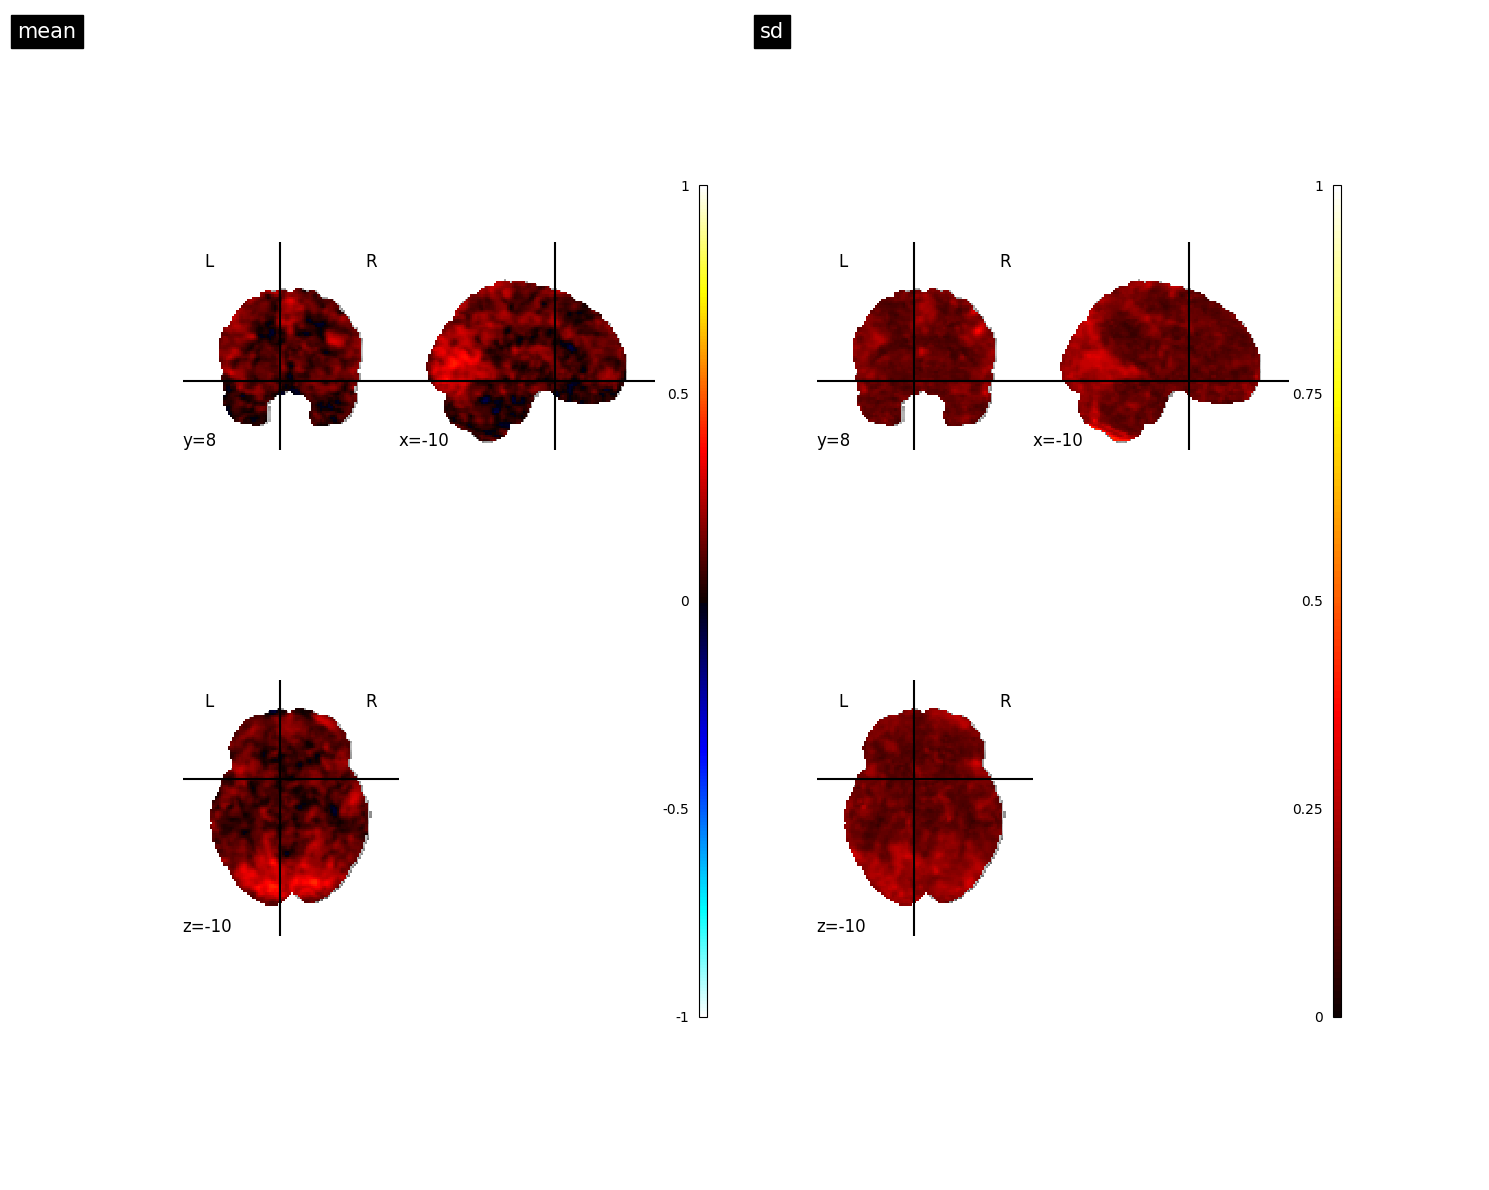

In [8]:
icc_maps = [icc_mean, icc_sd]
icc_names = ['icc_mean', 'icc_sd']

plot_icc_maps(maps=icc_maps, names=icc_names, 
              coordinates=(-10, 8, -10),vmax=1)

## Between Subject Var est

In [9]:
bs_mean, bs_sd = mean_sd_img(bs_imgs)

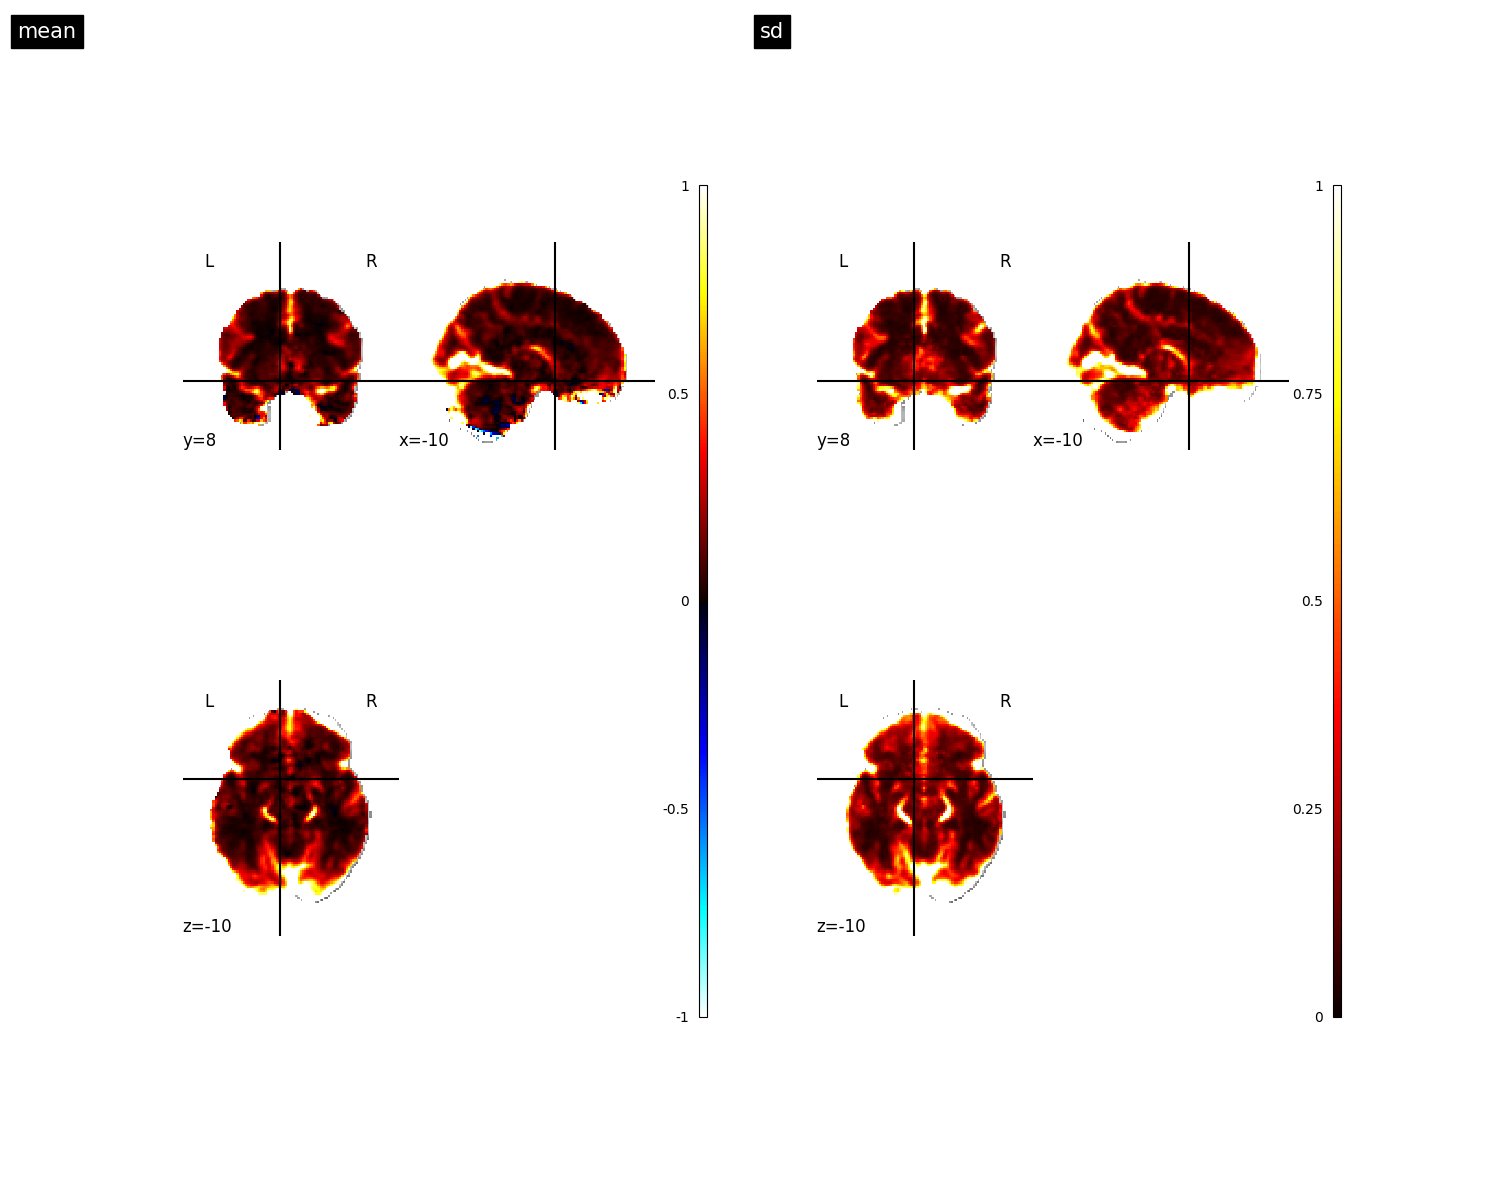

In [10]:
bs_maps = [bs_mean, bs_sd]
bs_names = ['bs_mean', 'bs_sd']

plot_icc_maps(maps=bs_maps, names=bs_names, 
              coordinates=(-10, 8, -10),vmax=1)

## Within Subject Var est

In [11]:
ws_mean, ws_sd = mean_sd_img(ws_imgs)

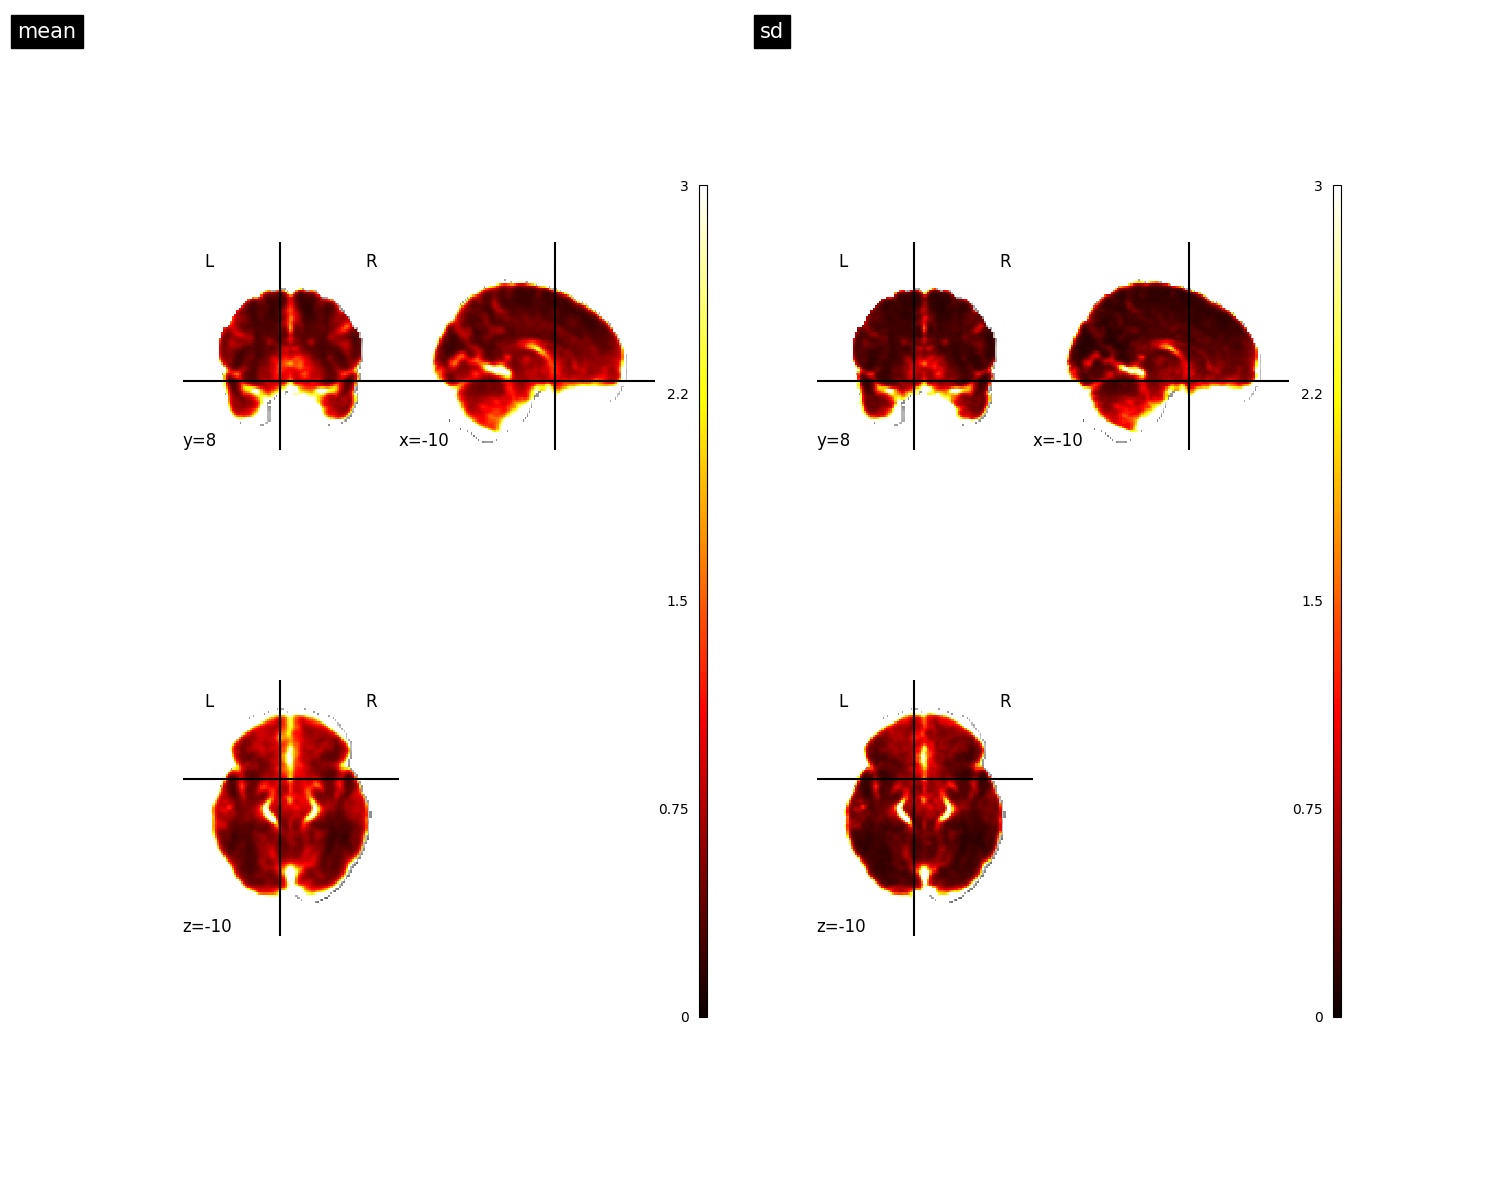

In [12]:
ws_maps = [ws_mean, ws_sd]
ws_names = ['ws_mean', 'ws_sd']

plot_icc_maps(maps=ws_maps, names=ws_names, 
              coordinates=(-10, 8, -10),vmax=3)

# Loading files, Extracting median ICC and providing distribution

For Aim 1 and Aim 2 state would include:
"Second, the range and distribution of median ICCs across each study (three) and analytic decision category (four) are plotted across suprathreshold task-positive and subthreshold ICCs using Rainclouds (Allen et al., 2019) and the median and standard deviation is reported in a table."

While included here to rank and contain some information, plots will be created in R using raincloud features that are more powerful

In [13]:
# icc datasets
df_icc_supra = process_dataset(icc_imgs, mask_supra, out_icc_supra)
df_icc_sub = process_dataset(icc_imgs, mask_sub, out_icc_sub)
df_icc_nacc = process_dataset_roi(icc_imgs, left_mask=left_nacc, right_mask=right_nacc, out_file=out_icc_nacc)
# msbs datasets
df_bs_supra = process_dataset(bs_imgs, mask_supra, out_bs_supra)
df_bs_sub = process_dataset(bs_imgs, mask_sub, out_bs_sub)
df_bs_nacc = process_dataset_roi(bs_imgs, left_mask=left_nacc, right_mask=right_nacc, out_file=out_bs_nacc)

# msws datasets
df_ws_supra = process_dataset(ws_imgs, mask_supra, out_ws_supra)
df_ws_sub = process_dataset(ws_imgs, mask_sub, out_ws_sub)
df_ws_nacc = process_dataset_roi(ws_imgs, left_mask=left_nacc, right_mask=right_nacc, out_file=out_ws_nacc)

file /scratch.global/mdemiden/analyses_reliability/file_output/sample-abcd_type-run_stats-est_mask-wilson-supra.tsv doesnt exist, creating
file /scratch.global/mdemiden/analyses_reliability/file_output/sample-abcd_type-run_stats-est_mask-wilson-sub.tsv doesnt exist, creating
file /scratch.global/mdemiden/analyses_reliability/file_output/sample-abcd_type-run_stats-est_mask-nacc.tsv doesnt exist, creating
file /scratch.global/mdemiden/analyses_reliability/file_output/sample-abcd_type-run_stats-bs_mask-wilson-supra.tsv doesnt exist, creating
file /scratch.global/mdemiden/analyses_reliability/file_output/sample-abcd_type-run_stats-bs_mask-wilson-sub.tsv doesnt exist, creating
file /scratch.global/mdemiden/analyses_reliability/file_output/sample-abcd_type-run_stats-bs_mask-nacc.tsv doesnt exist, creating
file /scratch.global/mdemiden/analyses_reliability/file_output/sample-abcd_type-run_stats-ws_mask-wilson-supra.tsv doesnt exist, creating
file /scratch.global/mdemiden/analyses_reliability/

### sort ICC by median est + img of highest

In [14]:
df_icc_supra.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
204,MNI152_wilson-supra,contrast-Sgain-Base,mot-opt2,mod-CueMod,fwhm-8.4,0.433
69,MNI152_wilson-supra,contrast-Sgain-Base,mot-opt3,mod-CueMod,fwhm-8.4,0.426
84,MNI152_wilson-supra,contrast-Sgain-Base,mot-opt4,mod-CueMod,fwhm-8.4,0.423
203,MNI152_wilson-supra,contrast-Sgain-Base,mot-opt2,mod-CueMod,fwhm-7.2,0.416
68,MNI152_wilson-supra,contrast-Sgain-Base,mot-opt3,mod-CueMod,fwhm-7.2,0.407
...,...,...,...,...,...,...
235,MNI152_wilson-supra,contrast-Sgain-Neut,mot-opt2,mod-FixMod,fwhm-3.6,-0.023
236,MNI152_wilson-supra,contrast-Sgain-Neut,mot-opt2,mod-FixMod,fwhm-4.8,-0.035
237,MNI152_wilson-supra,contrast-Sgain-Neut,mot-opt2,mod-FixMod,fwhm-6.0,-0.047
238,MNI152_wilson-supra,contrast-Sgain-Neut,mot-opt2,mod-FixMod,fwhm-7.2,-0.059


In [15]:
df_icc_sub.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
189,MNI152_wilson-sub,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-8.4,0.357
204,MNI152_wilson-sub,contrast-Sgain-Base,mot-opt2,mod-CueMod,fwhm-8.4,0.349
188,MNI152_wilson-sub,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-7.2,0.343
203,MNI152_wilson-sub,contrast-Sgain-Base,mot-opt2,mod-CueMod,fwhm-7.2,0.330
187,MNI152_wilson-sub,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-6.0,0.326
...,...,...,...,...,...,...
235,MNI152_wilson-sub,contrast-Sgain-Neut,mot-opt2,mod-FixMod,fwhm-3.6,-0.015
236,MNI152_wilson-sub,contrast-Sgain-Neut,mot-opt2,mod-FixMod,fwhm-4.8,-0.024
237,MNI152_wilson-sub,contrast-Sgain-Neut,mot-opt2,mod-FixMod,fwhm-6.0,-0.034
238,MNI152_wilson-sub,contrast-Sgain-Neut,mot-opt2,mod-FixMod,fwhm-7.2,-0.044


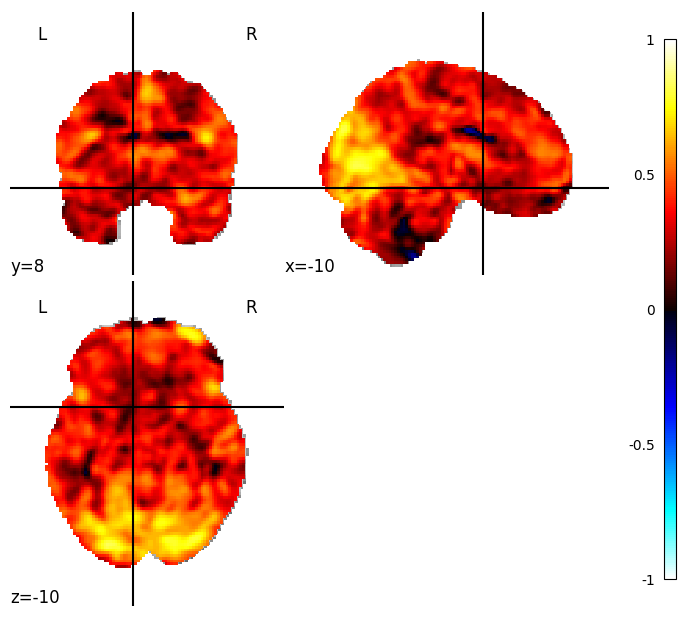

In [16]:
icc_ind = 188
plot_top_map(img=icc_imgs, img_index=icc_ind, coordinates=(-10, 8, -10), vmax=1)

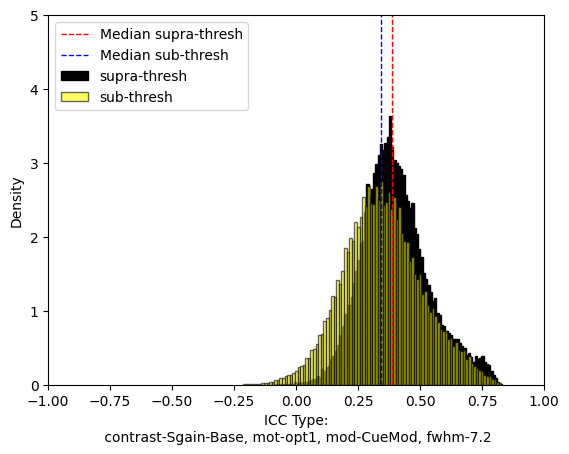

In [17]:
model_name = df_icc_supra.loc[icc_ind, ['con','motion', 'model', 'fwhm']].values
xlab = f'ICC Type:\n {", ".join(model_name)}'

plot_dist_imgs(imgs=icc_imgs, img_index=icc_ind,
               mask_supra=mask_supra, mask_sub=mask_sub,
               bins=100, ylim=(0,5),xlim=(-1,1),dec_round=3,
               xlab=xlab)

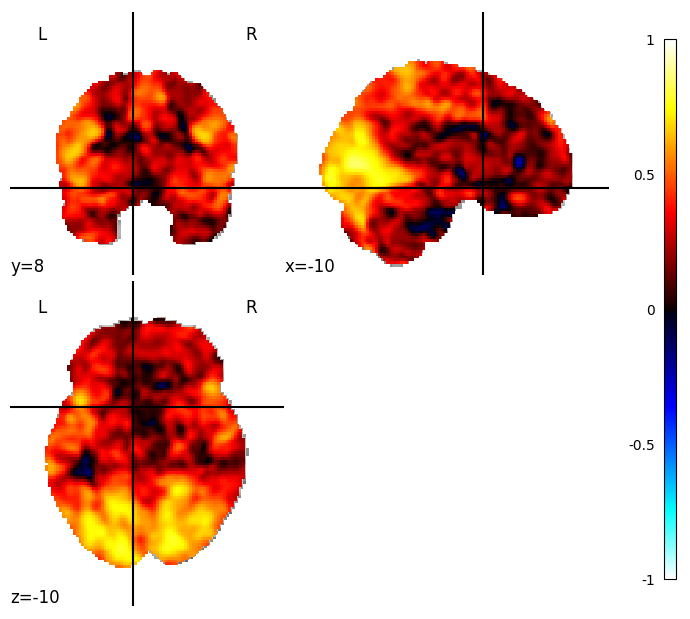

In [18]:
icc_ind = 24
plot_top_map(img=icc_imgs, img_index=icc_ind, coordinates=(-10, 8, -10), vmax=1)

#### select `lowest/highest` ICC from specr

In [19]:
# match to top session test-retest model
conditions = (
    (df_icc_supra["mask"] == "MNI152_wilson-supra") &
    (df_icc_supra["con"] == "contrast-Sgain-Neut") &
    (df_icc_supra["motion"] == "mot-opt3") &
    (df_icc_supra["model"] == "mod-FixMod") &
    (df_icc_supra["fwhm"] == "fwhm-3.6")
)


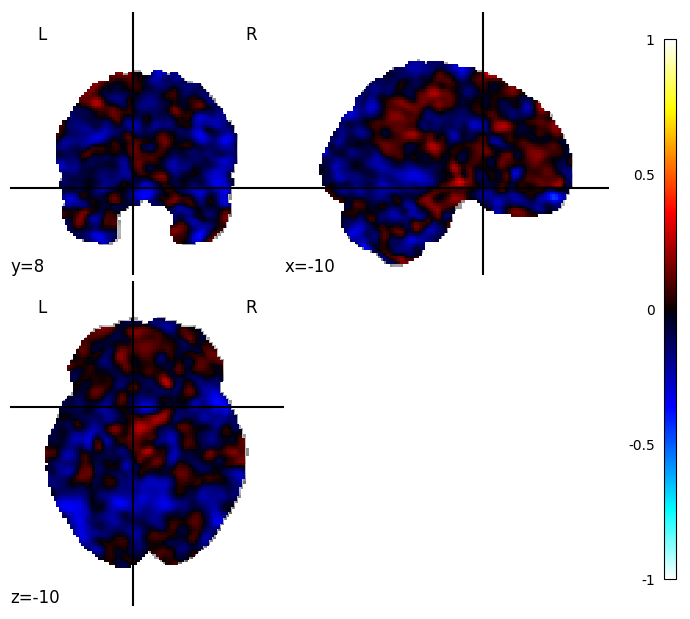

In [20]:
icc_lowest = df_icc_supra.sort_values(by='median_est', ascending=True).index[0]
plot_top_map(img=icc_imgs, img_index=icc_lowest, coordinates=(-10, 8, -10), vmax=1)

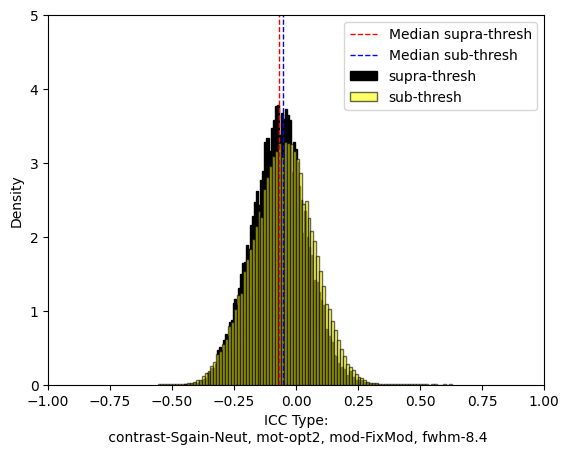

In [21]:
model_name = df_icc_supra.loc[icc_lowest, ['con', 'motion', 'model', 'fwhm']].values
xlab = f'ICC Type:\n {", ".join(model_name)}'

plot_dist_imgs(imgs=icc_imgs, img_index=icc_lowest,
               mask_supra=mask_supra, mask_sub=mask_sub,
               bins=100, ylim=(0,5),xlim=(-1,1),dec_round=3,
               xlab=xlab)

In [22]:
# match to top session test-retest model
conditions = (
    (df_icc_supra["mask"] == "MNI152_wilson-supra") &
    (df_icc_supra["con"] == "contrast-Sgain-Base") &
    (df_icc_supra["motion"] == "mot-opt2") &
    (df_icc_supra["model"] == "mod-CueMod") &
    (df_icc_supra["fwhm"] == "fwhm-8.4")
)

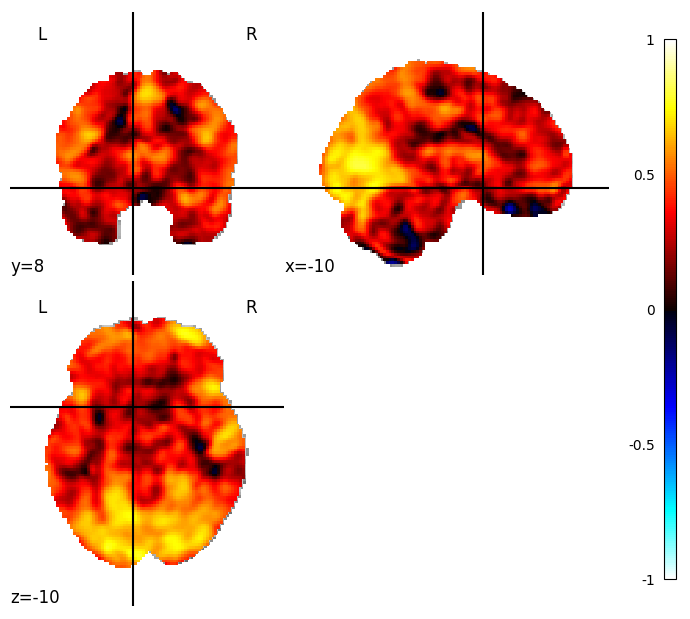

In [23]:
icc_highest = df_icc_supra.sort_values(by='median_est', ascending=False).index[0]
plot_top_map(img=icc_imgs, img_index=icc_highest, coordinates=(-10, 8, -10), vmax=1)

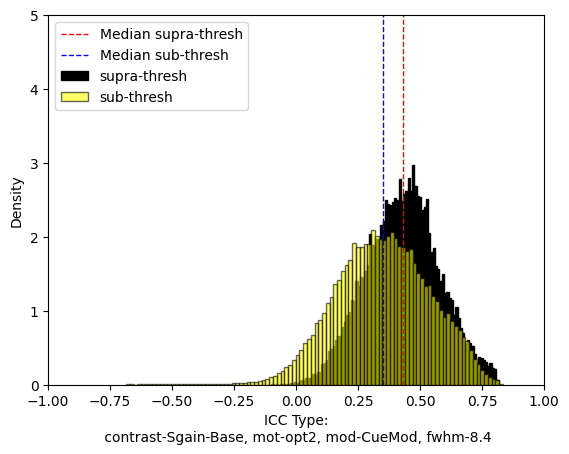

In [24]:
model_name = df_icc_supra.loc[icc_highest, ['con', 'motion', 'model', 'fwhm']].values
xlab = f'ICC Type:\n {", ".join(model_name)}'

plot_dist_imgs(imgs=icc_imgs, img_index=icc_highest,
               mask_supra=mask_supra, mask_sub=mask_sub,
               bins=100, ylim=(0,5),xlim=(-1,1),dec_round=3,
               xlab=xlab)

### sort Between Subject Var by median est + img of highest

In [25]:
df_bs_supra.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
185,MNI152_wilson-supra,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-3.6,0.679
186,MNI152_wilson-supra,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-4.8,0.569
125,MNI152_wilson-supra,contrast-Lgain-Base,mot-opt1,mod-CueMod,fwhm-3.6,0.560
187,MNI152_wilson-supra,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-6.0,0.496
200,MNI152_wilson-supra,contrast-Sgain-Base,mot-opt2,mod-CueMod,fwhm-3.6,0.489
...,...,...,...,...,...,...
235,MNI152_wilson-supra,contrast-Sgain-Neut,mot-opt2,mod-FixMod,fwhm-3.6,-0.015
236,MNI152_wilson-supra,contrast-Sgain-Neut,mot-opt2,mod-FixMod,fwhm-4.8,-0.017
237,MNI152_wilson-supra,contrast-Sgain-Neut,mot-opt2,mod-FixMod,fwhm-6.0,-0.018
238,MNI152_wilson-supra,contrast-Sgain-Neut,mot-opt2,mod-FixMod,fwhm-7.2,-0.019


In [26]:
df_bs_sub.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
185,MNI152_wilson-sub,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-3.6,0.874
186,MNI152_wilson-sub,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-4.8,0.741
125,MNI152_wilson-sub,contrast-Lgain-Base,mot-opt1,mod-CueMod,fwhm-3.6,0.726
187,MNI152_wilson-sub,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-6.0,0.653
126,MNI152_wilson-sub,contrast-Lgain-Base,mot-opt1,mod-CueMod,fwhm-4.8,0.612
...,...,...,...,...,...,...
235,MNI152_wilson-sub,contrast-Sgain-Neut,mot-opt2,mod-FixMod,fwhm-3.6,-0.015
236,MNI152_wilson-sub,contrast-Sgain-Neut,mot-opt2,mod-FixMod,fwhm-4.8,-0.016
237,MNI152_wilson-sub,contrast-Sgain-Neut,mot-opt2,mod-FixMod,fwhm-6.0,-0.017
238,MNI152_wilson-sub,contrast-Sgain-Neut,mot-opt2,mod-FixMod,fwhm-7.2,-0.019


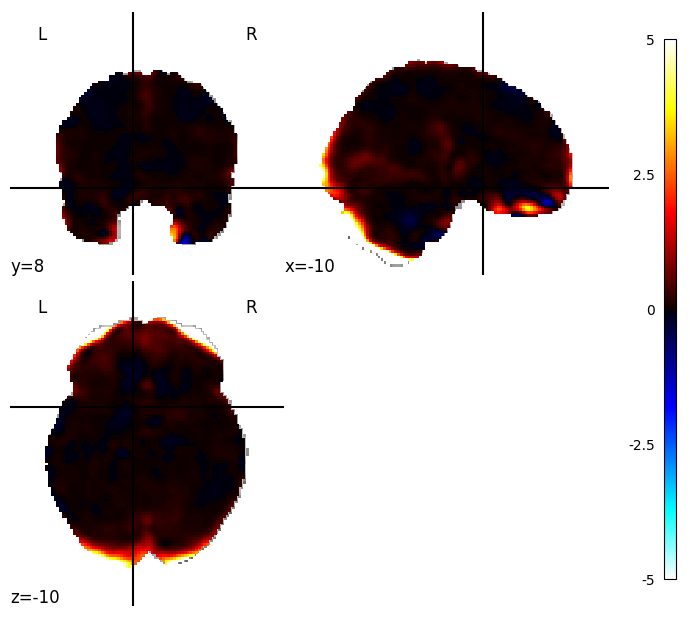

In [27]:
bs_ind = 184
plot_top_map(img=bs_imgs, img_index=bs_ind, coordinates=(-10, 8, -10), vmax=5)

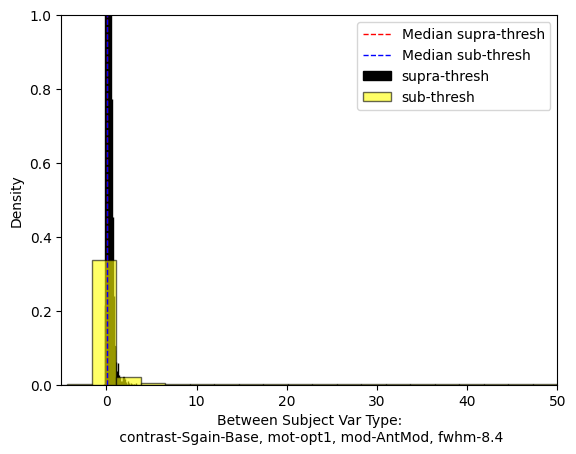

In [28]:
model_name = df_bs_supra.loc[bs_ind, ['con', 'motion','model', 'fwhm']].values
xlab = f'Between Subject Var Type:\n {", ".join(model_name)}'

plot_dist_imgs(imgs=bs_imgs, img_index=bs_ind,
               mask_supra=mask_supra, mask_sub=mask_sub,
               bins=500,ylim=(0,1),xlim=(-5,50),
               xlab=xlab)

### sort Within Subject Var by median est + img of highest

In [29]:
df_ws_supra.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
185,MNI152_wilson-supra,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-3.6,1.428
125,MNI152_wilson-supra,contrast-Lgain-Base,mot-opt1,mod-CueMod,fwhm-3.6,1.355
155,MNI152_wilson-supra,contrast-Lgain-Neut,mot-opt1,mod-CueMod,fwhm-3.6,1.350
190,MNI152_wilson-supra,contrast-Sgain-Base,mot-opt1,mod-FixMod,fwhm-3.6,1.281
215,MNI152_wilson-supra,contrast-Sgain-Neut,mot-opt1,mod-CueMod,fwhm-3.6,1.189
...,...,...,...,...,...,...
34,MNI152_wilson-supra,contrast-Lgain-Neut,mot-opt3,mod-AntMod,fwhm-8.4,0.074
108,MNI152_wilson-supra,contrast-Sgain-Neut,mot-opt4,mod-AntMod,fwhm-7.2,0.068
49,MNI152_wilson-supra,contrast-Lgain-Neut,mot-opt4,mod-AntMod,fwhm-8.4,0.065
94,MNI152_wilson-supra,contrast-Sgain-Neut,mot-opt3,mod-AntMod,fwhm-8.4,0.063


In [30]:
df_ws_sub.sort_values(by='median_est', ascending=False)

,mask,con,motion,model,fwhm,median_est
155,MNI152_wilson-sub,contrast-Lgain-Neut,mot-opt1,mod-CueMod,fwhm-3.6,2.162
125,MNI152_wilson-sub,contrast-Lgain-Base,mot-opt1,mod-CueMod,fwhm-3.6,2.138
185,MNI152_wilson-sub,contrast-Sgain-Base,mot-opt1,mod-CueMod,fwhm-3.6,2.138
190,MNI152_wilson-sub,contrast-Sgain-Base,mot-opt1,mod-FixMod,fwhm-3.6,2.038
215,MNI152_wilson-sub,contrast-Sgain-Neut,mot-opt1,mod-CueMod,fwhm-3.6,1.973
...,...,...,...,...,...,...
34,MNI152_wilson-sub,contrast-Lgain-Neut,mot-opt3,mod-AntMod,fwhm-8.4,0.107
108,MNI152_wilson-sub,contrast-Sgain-Neut,mot-opt4,mod-AntMod,fwhm-7.2,0.098
94,MNI152_wilson-sub,contrast-Sgain-Neut,mot-opt3,mod-AntMod,fwhm-8.4,0.095
49,MNI152_wilson-sub,contrast-Lgain-Neut,mot-opt4,mod-AntMod,fwhm-8.4,0.093


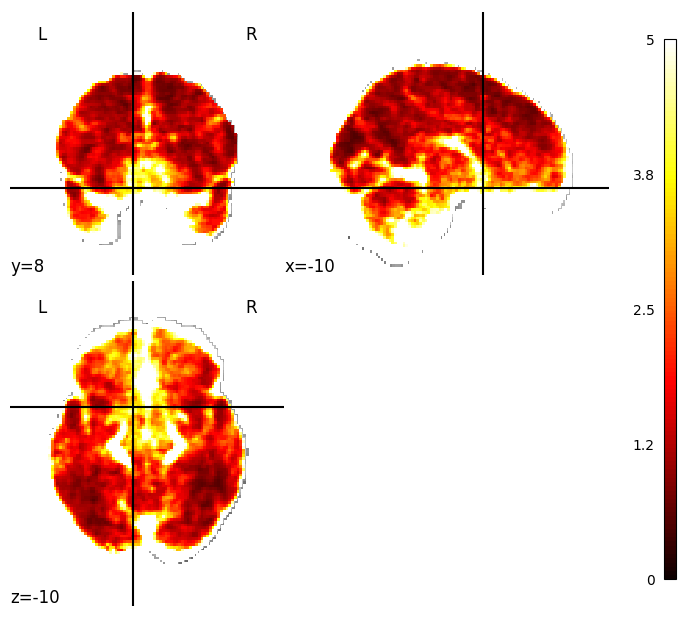

In [31]:
ws_ind = 185
plot_top_map(img=ws_imgs, img_index=ws_ind, coordinates=(-10, 8, -10), vmax=5)

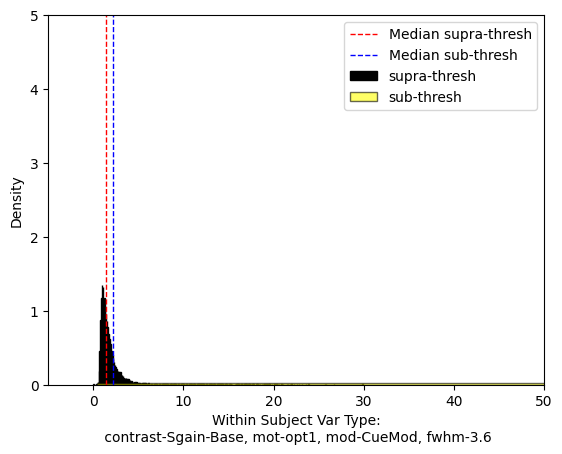

In [32]:
model_name = df_ws_supra.loc[ws_ind, ['con', 'motion','model', 'fwhm']].values
xlab = f'Within Subject Var Type:\n {", ".join(model_name)}'

plot_dist_imgs(imgs=ws_imgs, img_index=ws_ind,
               mask_supra=mask_supra, mask_sub=mask_sub,
               bins=500,ylim=(0,5),xlim=(-5,50),
               xlab=xlab)

# Group Maps for supplemental

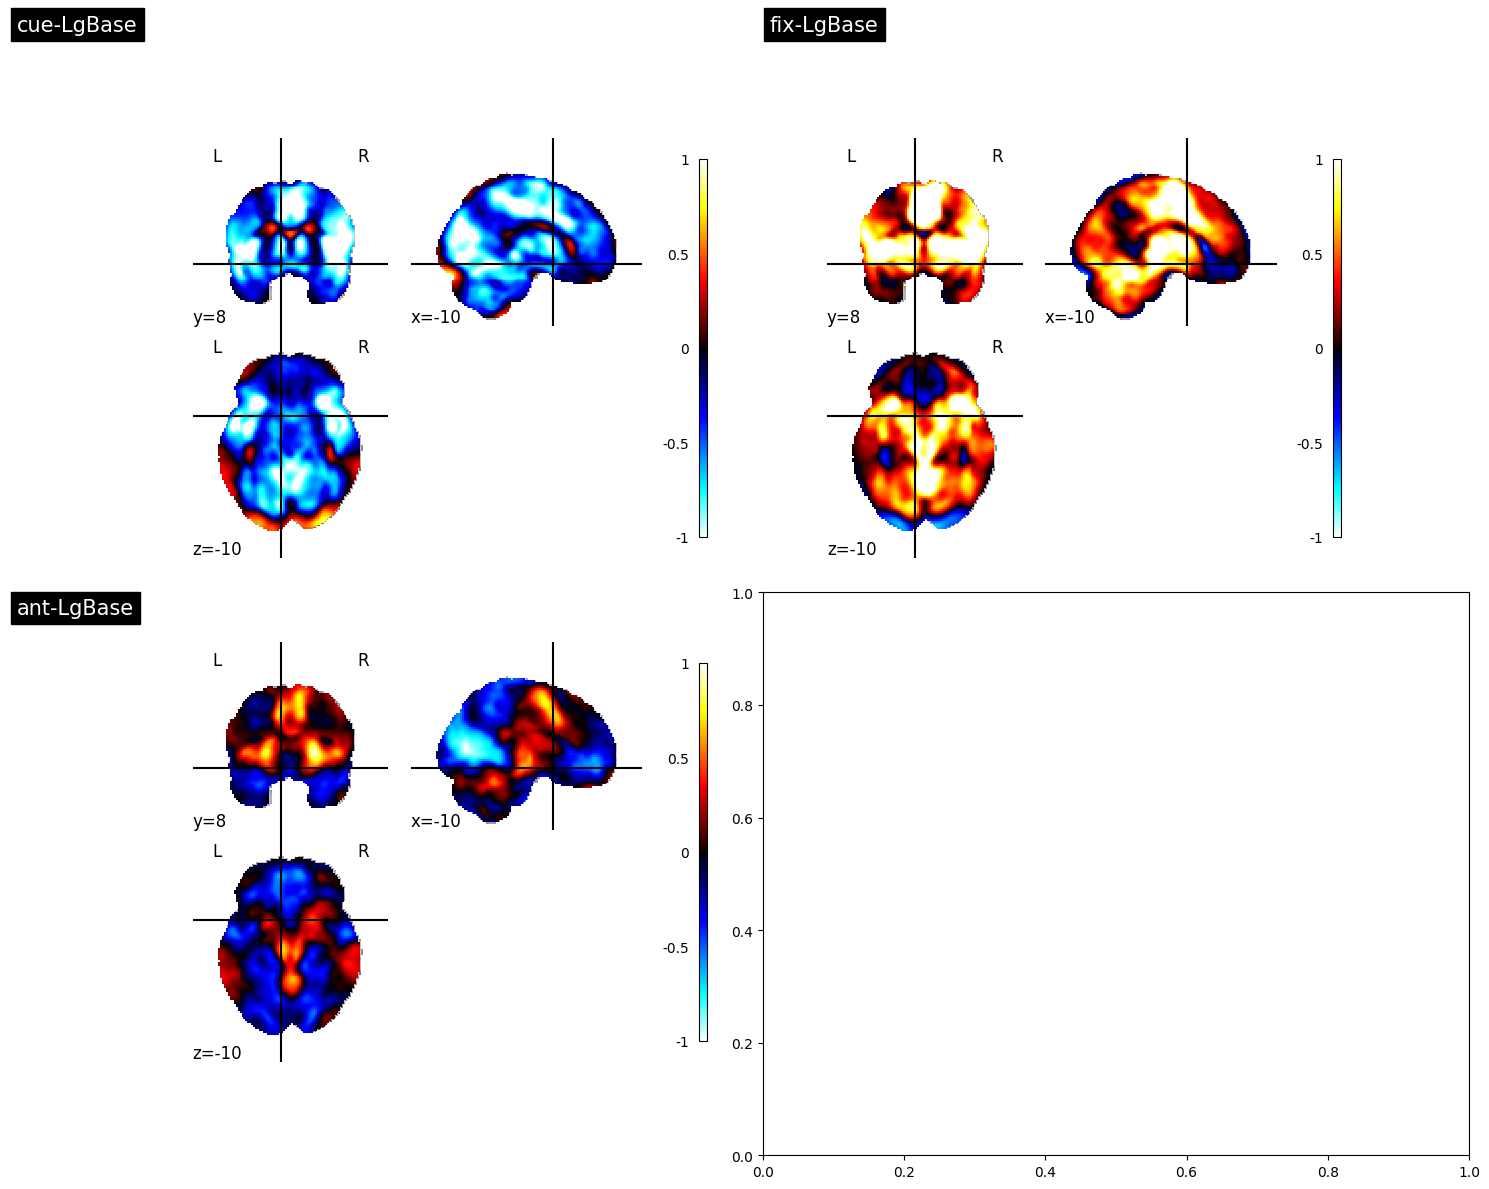

In [33]:
cue='contrast-Lgain-Base_mask-mni152_mot-opt2_mod-CueMod_fwhm-8.4'
fix='contrast-Lgain-Base_mask-mni152_mot-opt2_mod-FixMod_fwhm-8.4'
ant='contrast-Lgain-Base_mask-mni152_mot-opt2_mod-AntMod_fwhm-8.4'
group_maps=os.path.join(group_out,f'ses-{ses}','session')
cue_map=glob(os.path.join(group_maps,f'subs-*_ses-{ses}_task-{task}_type-session_{cue}_stat-cohensd.nii.gz'))[0]
fix_map=glob(os.path.join(group_maps,f'subs-*_ses-{ses}_task-{task}_type-session_{fix}_stat-cohensd.nii.gz'))[0]
ant_map=glob(os.path.join(group_maps,f'subs-*_ses-{ses}_task-{task}_type-session_{ant}_stat-cohensd.nii.gz'))[0]
grp_maps = [cue_map,fix_map,ant_map]
grp_labs = ["model_cue-LgBase","model_fix-LgBase","model_ant-LgBase"]
plot_icc_maps(maps=grp_maps, names=grp_labs, 
              coordinates=(-10, 8, -10),vmax=1)

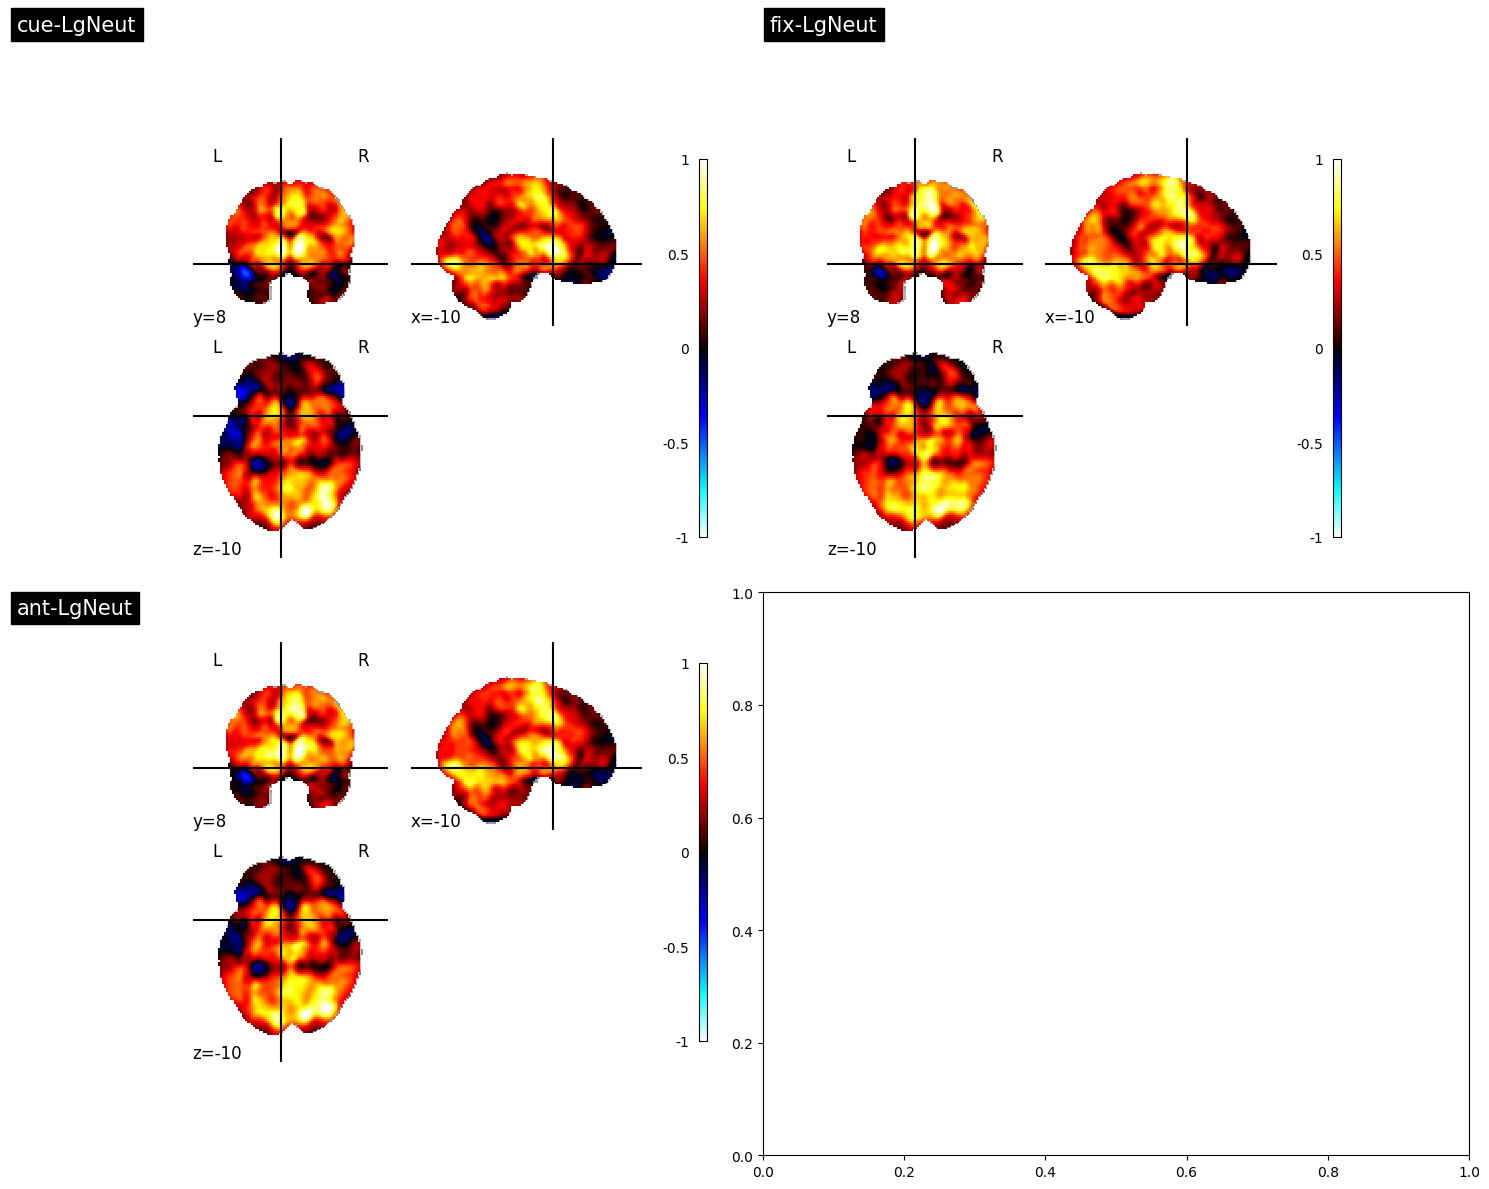

In [34]:
cue='contrast-Lgain-Neut_mask-mni152_mot-opt2_mod-CueMod_fwhm-8.4'
fix='contrast-Lgain-Neut_mask-mni152_mot-opt2_mod-FixMod_fwhm-8.4'
ant='contrast-Lgain-Neut_mask-mni152_mot-opt2_mod-AntMod_fwhm-8.4'
group_maps=os.path.join(group_out,f'ses-{ses}','session')
cue_map=glob(os.path.join(group_maps,f'subs-*_ses-{ses}_task-{task}_type-session_{cue}_stat-cohensd.nii.gz'))[0]
fix_map=glob(os.path.join(group_maps,f'subs-*_ses-{ses}_task-{task}_type-session_{fix}_stat-cohensd.nii.gz'))[0]
ant_map=glob(os.path.join(group_maps,f'subs-*_ses-{ses}_task-{task}_type-session_{ant}_stat-cohensd.nii.gz'))[0]
grp_maps = [cue_map,fix_map,ant_map]
grp_labs = ["model_cue-LgNeut","model_fix-LgNeut","model_ant-LgNeut"]
plot_icc_maps(maps=grp_maps, names=grp_labs, 
              coordinates=(-10, 8, -10),vmax=1)

## ROI mask plot

In [39]:
left_nac_dat = image.load_img(left_nacc)
right_nac_dat = image.load_img(right_nacc)
data1 = left_nac_dat.get_fdata()
data2 = right_nac_dat.get_fdata()
combined_data = data1 + data2
nacc = nib.Nifti1Image(combined_data, affine=left_nac_dat.affine)

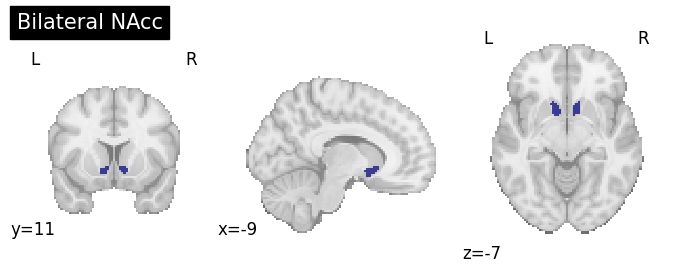

In [40]:
plotting.plot_roi(nacc, title='Bilateral NAcc',draw_cross=False)

# Group-wise similarity

## Jaccards & spearman similarity

As described in the registered report:

*"Jaccard similarity coefficient is sensitive to thresholding and sample size (Bennett & Miller, 2010), in Aim 1 an equal sample size (e.g., N ~ 60) is chosen for each study to compare how the similarity between sessions varies across studies. For all 360 pipelines, a group-level (average) activation map is estimated for each session. In the case of the Jaccard coefficient, the group maps are thresholded at p < .001. In the case of the Spearman coefficient, the group maps are masked using a suprathreshold task-positive map from NeuroVault. Then, the paths for the pipelines and sessions are called using the pairwise_similarity within the similarity.py script. The resulting coefficients report the similarity between analytic pipelines and sessions for each study. For each study, the coefficients are plotted to reflect the distribution and range of coefficients. Both Jaccards and Spearman correlation are reported separately. Like Aim 1 & Aim 2, two HLMs are used to regress the Jaccard coefficients and Spearman correlation on the [four] analytic decisions nested within study. Multiple comparisons corrections are applied using the Tukey adjustment."*

In [35]:
contrasts = [
    'Lgain-Neut', 'Sgain-Neut',
    'Lgain-Base', 'Sgain-Base'
]

# Model permutations
if sample in ['abcd', 'AHRB']:
    voxel = 2.4
    opts = np.array([1.5,  2, 2.5, 3, 3.5])
    fwhm_opt = list(np.round(voxel * opts, 1))
elif sample in 'MLS':
    voxel = 4
    inh_smooth_weight = .50
    opts = np.array([1.5, 2, 2.5, 3, 3.5])*inh_smooth_weight
    fwhm_opt = list(np.round(voxel * opts, 1))

# only including 4; opt 5 is opt3 + subj mFD < .9 & opt6 is opt4 + subj mFD < .9. 
motion_opt = ["opt1", "opt2", "opt3", "opt4"]
modtype_opt = ["CueMod", "AntMod", "FixMod"]

permutation_list = list(product(contrasts, fwhm_opt, motion_opt, modtype_opt))

In [36]:
threshold = .4 # mod since t -> d transform
similar_list = []
mask_lab = 'wilson-supra'
n = 0
for con, fwhm, motion, model in permutation_list:
    n = n + 1
    print(f'Running {n} out of {len(permutation_list)}')
    # jaccard/ spearman similarity between session 1 and session 2
    img1 = f'{group_out}/ses-{ses}/{calc_type}/*type-{calc_type}01_contrast-{con}_mask-mni152_mot-{motion}_mod-{model}_fwhm-{fwhm}_stat-cohensd.nii.gz'
    img2 = f'{group_out}/ses-{ses}/{calc_type}/*type-{calc_type}02_contrast-{con}_mask-mni152_mot-{motion}_mod-{model}_fwhm-{fwhm}_stat-cohensd.nii.gz'
    jaccard = similarity.image_similarity(imgfile1=img1, imgfile2=img2, thresh = threshold, similarity_type = 'jaccard')
    spearman = similarity.image_similarity(imgfile1=img1, imgfile2=img2, mask=mask_supra, similarity_type = 'spearman')
    
    try:
        ses_icc = f'{icc_est}/*_contrast-{con}_mask-mni152_mot-{motion}_mod-{model}_fwhm-{fwhm}*stat-est.nii.gz'
        run1 = f'{group_out}/ses-{ses}/{calc_type}/*type-{calc_type}01_contrast-{con}_mask-mni152_mot-{motion}_mod-{model}_fwhm-{fwhm}_stat-cohensd.nii.gz'
        run2 = f'{group_out}/ses-{ses}/{calc_type}/*type-{calc_type}02_contrast-{con}_mask-mni152_mot-{motion}_mod-{model}_fwhm-{fwhm}_stat-cohensd.nii.gz'
        run1_spear = similarity.image_similarity(imgfile1=ses_icc, imgfile2=run1, mask=mask_supra, similarity_type='spearman')
        run2_spear = similarity.image_similarity(imgfile1=ses_icc, imgfile2=run2, mask=mask_supra, similarity_type='spearman')
    except Exception as e:
        print(f"contrast-{con}_mask-mni152_mot-{motion}_mod-{model}_fwhm-{fwhm}. An error occurred: {e}")
        run1_spear = np.nan
        run2_spear = np.nan


    similar_list.append({
        'con': con,
        'fwhm': fwhm,
        'motion': motion,
        'model': model,
        'jaccard': jaccard,
        'spearman': spearman,
        'run1_icc_cohensd': run1_spear,
        'run2_icc_cohensd': run2_spear,
        
    })
 

Running 1 out of 240
Running 2 out of 240
Running 3 out of 240
Running 4 out of 240
Running 5 out of 240
Running 6 out of 240
Running 7 out of 240
Running 8 out of 240
Running 9 out of 240
Running 10 out of 240
Running 11 out of 240
Running 12 out of 240
Running 13 out of 240
Running 14 out of 240
Running 15 out of 240
Running 16 out of 240
Running 17 out of 240
Running 18 out of 240
Running 19 out of 240
Running 20 out of 240
Running 21 out of 240
Running 22 out of 240
Running 23 out of 240
Running 24 out of 240
Running 25 out of 240
Running 26 out of 240
Running 27 out of 240
Running 28 out of 240
Running 29 out of 240
Running 30 out of 240
Running 31 out of 240
Running 32 out of 240
Running 33 out of 240
Running 34 out of 240
Running 35 out of 240
Running 36 out of 240
Running 37 out of 240
Running 38 out of 240
Running 39 out of 240
Running 40 out of 240
Running 41 out of 240
Running 42 out of 240
Running 43 out of 240
Running 44 out of 240
Running 45 out of 240
Running 46 out of 2

In [37]:
similarity_df = pd.DataFrame(similar_list)
similarity_df.to_csv(out_similarity, sep='\t', index=False)

# ICC, Between Sub Var, Within Sub Var random Sampling (ABCD Only)

In [6]:
seed_ns = pd.read_csv(seed_list, sep='\t', header=None)
seed_ns_list = seed_ns.iloc[:, 0].tolist()
ses='baselineYear1Arm1'
n_int = 50
min_n = 25
max_n = 525
n_range = list(range(min_n, max_n+n_int, n_int))
model='contrast-Sgain-Base_mask-mni152_mot-opt1_mod-CueMod_fwhm-8.4'

In [9]:
if not file_exists(icc_resample_file):
        print(f'file {icc_resample_file} doesnt exist, creating')
        df_boot = extract_median_rand(inp_dir=icc_resamp,model_name=model, ses=ses, task='MID', 
                                      subpra_mask=mask_supra, sub_mask=mask_sub, 
                                      seed_list=seed_ns_list, n_range=n_range)
        df_boot.to_csv(icc_resample_file, sep='\t', index=False)
else:
        print(f'Loading existing {icc_resample_file}')
        df_boot = pd.read_csv(icc_resample_file, sep='\t')


file /scratch.global/mdemiden/analyses_reliability/file_output/sample-abcd_ses-baselineYear1Arm1_type-bootsrap_stats-icc.tsv doesnt exist, creating


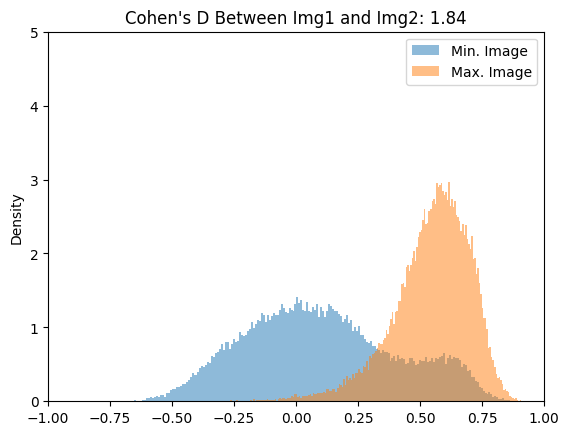

In [10]:
n1 = 25
sort_desc= df_boot[df_boot["subsample_n"] == n1].sort_values(by='icc_supra', ascending=True)
seed_lowest = sort_desc["seed"].iloc[0]
sort_ascend= df_boot[df_boot["subsample_n"] == n1].sort_values(by='icc_supra', ascending=False)
seed_highest = sort_ascend["seed"].iloc[0]
# plot
img1_25 = f'{icc_resamp}/seed-{seed_lowest}_subs-{n1}_task-MID_type-run_{model}_stat-est.nii.gz'
img2_25 = f'{icc_resamp}/seed-{seed_highest}_subs-{n1}_task-MID_type-run_{model}_stat-est.nii.gz'
dist_cohensd(min_img=img1_25, max_img=img2_25, mask=mask_supra,  bins=200, ylim=(0, 5), xlim=(-1, 1), dec_round=4, xlab='')

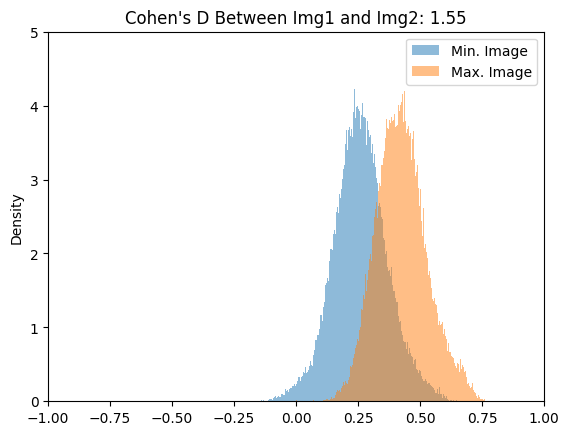

In [11]:
n2 = 225
sort_desc= df_boot[df_boot["subsample_n"] == n2].sort_values(by='icc_supra', ascending=True)
seed_lowest = sort_desc["seed"].iloc[0]
sort_ascend= df_boot[df_boot["subsample_n"] == n2].sort_values(by='icc_supra', ascending=False)
seed_highest = sort_ascend["seed"].iloc[0]
# plot
img1_225 = f'{icc_resamp}/seed-{seed_lowest}_subs-{n2}_task-MID_type-run_{model}_stat-est.nii.gz'
img2_225 = f'{icc_resamp}/seed-{seed_highest}_subs-{n2}_task-MID_type-run_{model}_stat-est.nii.gz'
dist_cohensd(min_img=img1_225, max_img=img2_225, mask=mask_supra,  bins=200, ylim=(0, 5), xlim=(-1, 1), dec_round=4, xlab='')

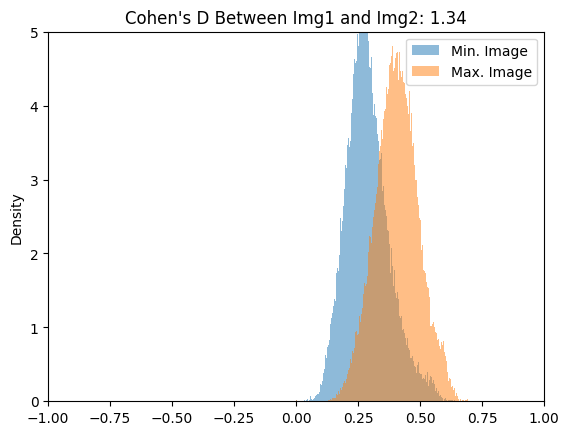

In [12]:
n3 = 525
sort_desc= df_boot[df_boot["subsample_n"] == n3].sort_values(by='icc_supra', ascending=True)
seed_lowest = sort_desc["seed"].iloc[0]
sort_ascend= df_boot[df_boot["subsample_n"] == n3].sort_values(by='icc_supra', ascending=False)
seed_highest = sort_ascend["seed"].iloc[0]
# plot
img1_525 = f'{icc_resamp}/seed-{seed_lowest}_subs-{n3}_task-MID_type-run_{model}_stat-est.nii.gz'
img2_525 = f'{icc_resamp}/seed-{seed_highest}_subs-{n3}_task-MID_type-run_{model}_stat-est.nii.gz'
dist_cohensd(min_img=img1_525, max_img=img2_525, mask=mask_supra,  bins=200, ylim=(0, 5), xlim=(-1, 1), dec_round=4, xlab='')

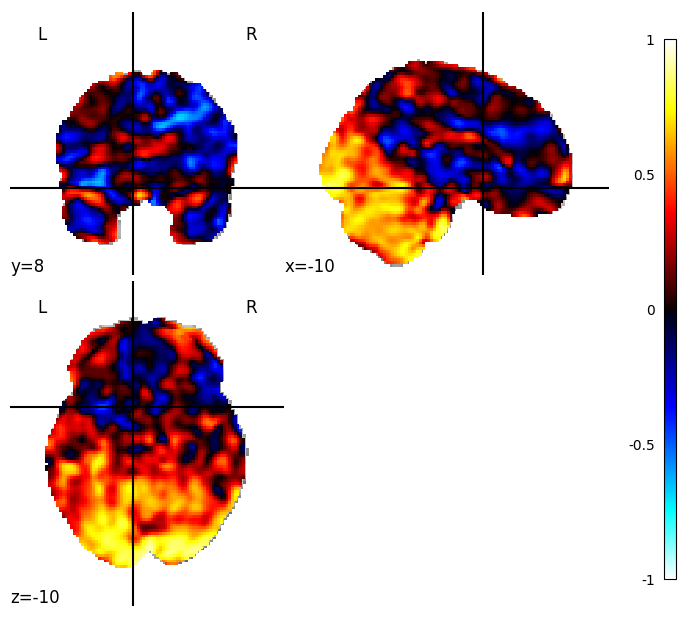

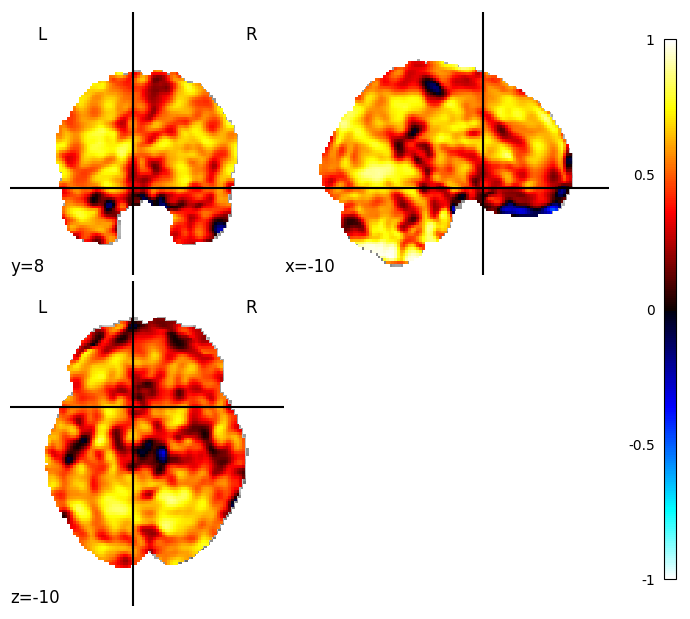

(None, None)

In [13]:
n_25_imgs = [img1_25,img2_25]
plot_top_map(img=n_25_imgs, img_index=0, coordinates=(-10, 8, -10), vmax=1),plot_top_map(img=n_25_imgs, img_index=1, coordinates=(-10, 8, -10), vmax=1)

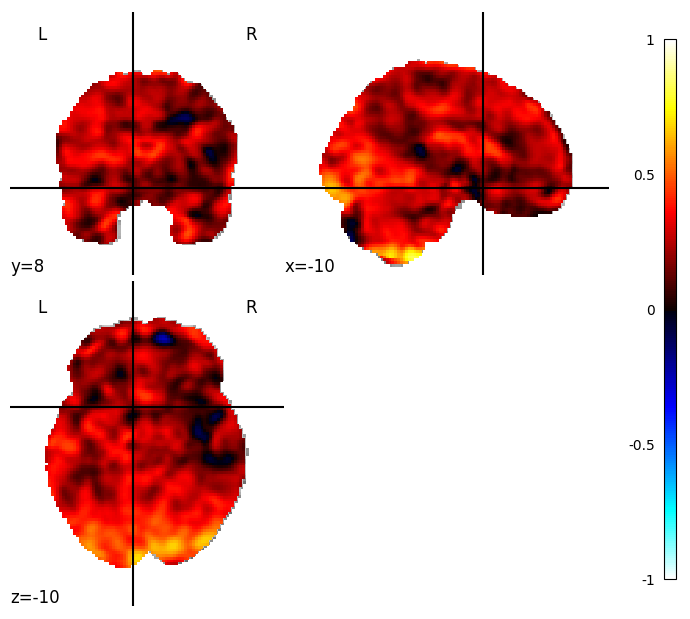

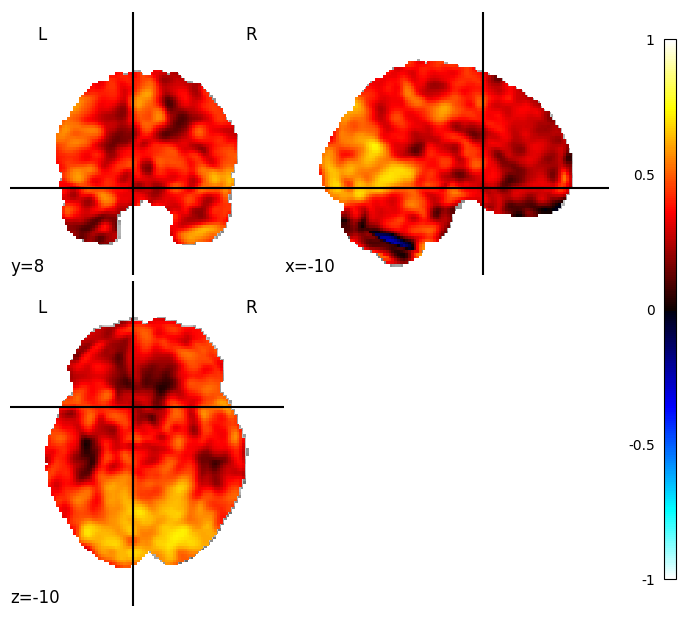

(None, None)

In [14]:
n_225_imgs = [img1_225,img2_225]
plot_top_map(img=n_225_imgs, img_index=0, coordinates=(-10, 8, -10), vmax=1),plot_top_map(img=n_225_imgs, img_index=1, coordinates=(-10, 8, -10), vmax=1)

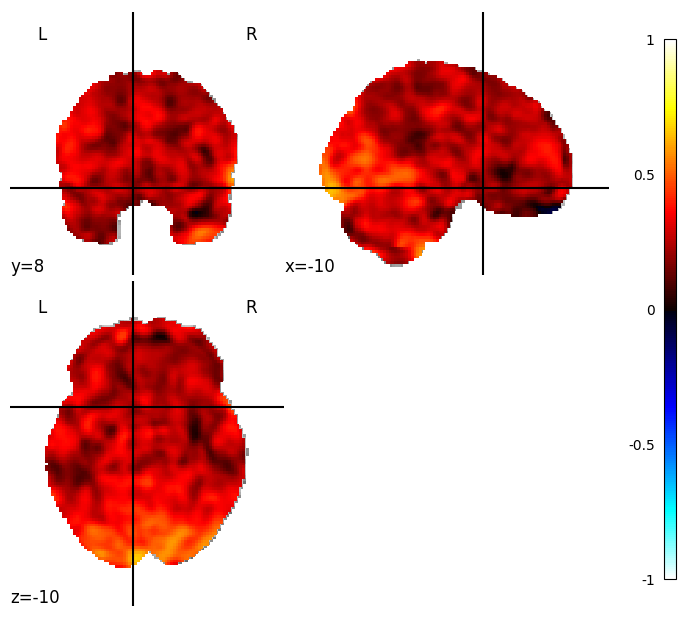

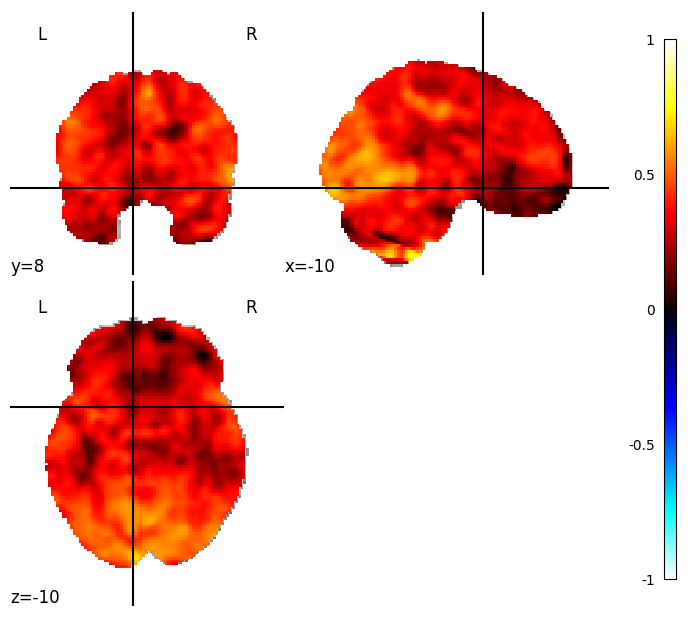

(None, None)

In [15]:
n_525_imgs = [img1_525,img2_525]
plot_top_map(img=n_525_imgs, img_index=0, coordinates=(-10, 8, -10), vmax=1),plot_top_map(img=n_525_imgs, img_index=1, coordinates=(-10, 8, -10), vmax=1)